In [1]:
RunID ='34be0913c3c8467a9061eb47b67628a5'

In [1]:
import pandas as pd 
import mlflow
import mlflow.sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
import numpy as np 
import subprocess
import json

In commandline run: <br>
mlflow models serve --model-uri runs:/RUNID/log_reg_model -p 1235

Querying the Model

In [2]:
df = pd.read_csv("../creditcard.csv")

In [8]:
input_json = df.iloc[:80].drop(["Time", "Class"],axis=1).to_json(orient="split")

In [9]:
proc = subprocess.run(["curl",  "-X", "POST", "-H",
"Content-Type:application/json; format=pandas-split",
"--data", input_json, "http://127.0.0.1:1235/invocations"],
stdout=subprocess.PIPE, encoding='utf-8')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31202  100   240  100 30962   6645   837k --:--:-- --:--:-- --:--:--  982k


In [10]:
output = proc.stdout
df2 = pd.DataFrame([json.loads(output)])
df2

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1,0,1,1,1,0,0,1,1,0,...,1,0,0,0,0,0,1,1,0,0


In [11]:
y_true = df.iloc[:80].Class
df2 = df2.T
eval_acc = accuracy_score(y_true, df2)
y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true, df2)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

Eval Acc 0.6625
Eval AUC 0.3291139240506329


/var/folders/b0/lvr6c0md2rb5v_rb1ngcc27h0000gn/T/ipykernel_86499/2007908655.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_true.iloc[-1] = 1


### Quering with scaling

In [3]:

normal = df[df.Class == 0].sample(frac=0.5, random_state=2020). reset_index(drop=True)
anomaly = df[df.Class == 1]
normal_train, normal_test = train_test_split(normal,
test_size = 0.2, random_state = 2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size = 0.2, random_state = 2020)
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop(["Time", "Class"],axis=1))


StandardScaler()

In [12]:
scaled_selection = scaler.transform(df.iloc[:80].drop(["Time", "Class"], axis=1))
input_json = pd.DataFrame(scaled_selection).to_json(orient="split")

In [13]:

proc = subprocess.run(["curl", "-X", "POST", "-H", 
                       "Content-Type:application/json; format=pandas-split", 
                       "--data", input_json, "http://127.0.0.1:1235/invocations"], 
                       stdout=subprocess.PIPE, encoding='utf-8')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31761  100   240  100 31521   8286  1062k --:--:-- --:--:-- --:--:-- 1292k


In [14]:
output = proc.stdout
preds = pd.DataFrame([json.loads(output)])
preds

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
y_true = df.iloc[:80].Class
preds = preds.T
eval_acc = accuracy_score(y_true, preds)
y_true.iloc[-1] = 1
eval_auc = roc_auc_score(y_true, preds)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)


Eval Acc 0.9875
Eval AUC 0.5


/var/folders/b0/lvr6c0md2rb5v_rb1ngcc27h0000gn/T/ipykernel_86499/4212978850.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_true.iloc[-1] = 1


### Batch Querying

there is a limit to how many data samples you can ask the model to make predictions on. <br>
The number 80 is really close to the maximum number of samples you can send at one time.
We can try batching the samples and making predictions one batch at a time.

In [16]:
test = df.iloc[:8000]
true = test.Class
test = scaler.transform(test.drop(["Time", "Class"], axis=1))
preds = []
batch_size = 80
for f in range(100):
    sample = pd.DataFrame(test[f*batch_size:(f+1)*batch_size]).to_json(orient="split")
    proc = subprocess.run(["curl",  "-X", "POST", "-H",
                          "Content-Type:application/json;format=pandas-split",
                          "--data",sample, "http://127.0.0.1:1235/invocations"],
                          stdout=subprocess.PIPE,
                          encoding='utf-8')
    output = proc.stdout
    resp = pd.DataFrame([json.loads(output)])
    preds = np.concatenate((preds, resp.values[0]))
eval_acc = accuracy_score(true, preds)
eval_auc = roc_auc_score(true, preds)
print("Eval Acc", eval_acc)
print("Eval AUC", eval_auc)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31761  100   240  100 31521   5581   715k --:--:-- --:--:-- --:--:--  861k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31790  100   240  100 31550  20203  2593k --:--:-- --:--:-- --:--:-- 3880k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31737  100   240  100 31497  17667  2264k --:--:-- --:--:-- --:--:-- 3099k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31740  100   240  100 31500  23713  3039k --:--:-- --:--:-- --:--:-- 4428k
  % Total    % Received % Xferd  Average Speed   Tim

Eval Acc 0.9995
Eval AUC 0.9230769230769231


100 31694  100   240  100 31454  19062  2439k --:--:-- --:--:-- --:--:-- 3095k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31713  100   240  100 31473  20248  2593k --:--:-- --:--:-- --:--:-- 3441k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31738  100   240  100 31498  18079  2317k --:--:-- --:--:-- --:--:-- 3099k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31746  100   240  100 31506  26336  3376k --:--:-- --:--:-- --:--:-- 5166k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31742  100   240  100 31502  18890  2421k --:--:

### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

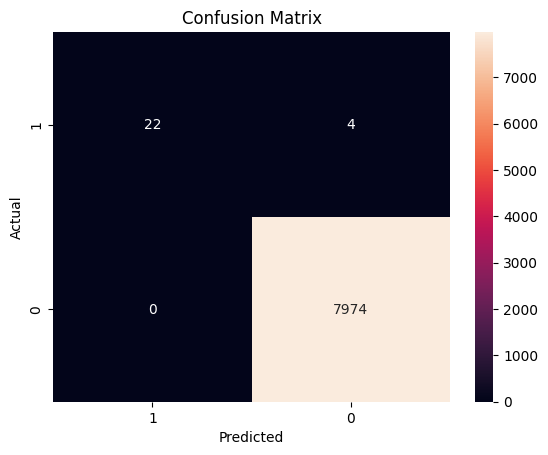

In [18]:
conf_matrix = confusion_matrix(true, preds)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g') 
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")